## 1. 环境初始化
- 安装所需依赖（transformers / datasets / trl / detoxify 等）
- 再次强调：所有实验默认运行在 BART-base 上
- 若环境已装过，可以跳过安装命令

In [1]:
# 安装依赖（若已经安装，可注释掉）
!pip install -q transformers datasets torch pandas scikit-learn matplotlib seaborn tqdm accelerate evaluate sacrebleu rouge-score detoxify sentence-transformers trl peft

In [2]:
import os
import random
import json
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm.auto import tqdm
from detoxify import Detoxify
from sentence_transformers import SentenceTransformer, util
from torch.optim import AdamW
from IPython.display import display, clear_output

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用设备: {device}')
print(f'PyTorch 版本: {torch.__version__}')

/Users/shatongzhu/Desktop/CS229/bart/.conda/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


使用设备: cpu
PyTorch 版本: 2.9.1


## 2. 数据加载与增强
复用 `test.ipynb` 中的数据处理逻辑：
1. 读取 ParaDetox TSV
2. 将每个 toxic 配对所有可用 neutral 版本（数据增强）
3. 保持 80/10/10 训练/验证/测试划分

In [3]:
DATA_FILE = 'paradetox.tsv'
if not os.path.exists(DATA_FILE):
    raise FileNotFoundError(f'未找到数据文件 {DATA_FILE}，请确认路径。')

df = pd.read_csv(DATA_FILE, sep='	')
print(f'原始样本数: {len(df)}')
df.head(3)

原始样本数: 11927


,toxic,neutral1,neutral2,neutral3
0,he had steel balls too !,he was brave too!,NaN,NaN
1,"dude should have been taken to api , he would ...",It would have been good if he went to api. He ...,NaN,NaN
2,"im not gonna sell the fucking picture , i just...","I'm not gonna sell the picture, i just want to...",NaN,NaN


In [4]:
def prepare_data(df):
    """
    复用基线 notebook 的处理：每个 toxic 对应所有非空 neutral 版本。
    """
    data_pairs = []
    for _, row in df.iterrows():
        toxic_text = str(row['toxic']).strip()
        if not toxic_text:
            continue
        neutral_versions = []
        for col in ['neutral1', 'neutral2', 'neutral3']:
            if pd.notna(row[col]):
                candidate = str(row[col]).strip()
                if candidate:
                    neutral_versions.append(candidate)
        for neutral in neutral_versions:
            data_pairs.append({'input': toxic_text, 'target': neutral})
    return pd.DataFrame(data_pairs)

processed_df = prepare_data(df)
print(f'增强后样本数: {len(processed_df)} (平均 {len(processed_df)/len(df):.2f} 条 / toxic)')
processed_df.head()

增强后样本数: 19743 (平均 1.66 条 / toxic)


,input,target
0,he had steel balls too !,he was brave too!
1,"dude should have been taken to api , he would ...",It would have been good if he went to api. He ...
2,"im not gonna sell the fucking picture , i just...","I'm not gonna sell the picture, i just want to..."
3,the garbage that is being created by cnn and o...,the news that is being created by cnn and othe...
4,the garbage that is being created by cnn and o...,The news that is being created by cnn and othe...


## 3. 数据集划分（含 RL 子集）
- 保持 80/10/10 划分
- 构造 RL 训练 / 评估子集（默认 8k / 1k，如不足则取全部）
- 保存为 Hugging Face Dataset 结构，后续 PPO 直接迭代

In [5]:
train_df, temp_df = train_test_split(processed_df, test_size=0.2, random_state=SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED)

print(f'训练集: {len(train_df)} 条')
print(f'验证集: {len(val_df)} 条')
print(f'测试集: {len(test_df)} 条')

train_dataset = Dataset.from_pandas(train_df[['input', 'target']].reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df[['input', 'target']].reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df[['input', 'target']].reset_index(drop=True))
dataset_dict = DatasetDict({'train': train_dataset, 'validation': val_dataset, 'test': test_dataset})
dataset_dict

训练集: 15794 条
验证集: 1974 条
测试集: 1975 条


DatasetDict({
    train: Dataset({
        features: ['input', 'target'],
        num_rows: 15794
    })
    validation: Dataset({
        features: ['input', 'target'],
        num_rows: 1974
    })
    test: Dataset({
        features: ['input', 'target'],
        num_rows: 1975
    })
})

In [6]:
# 数据集统计信息展示
summary = {
    'train_size': len(train_df),
    'validation_size': len(val_df),
    'test_size': len(test_df),
    'avg_input_len_train': train_df['input'].str.split().str.len().mean(),
    'avg_target_len_train': train_df['target'].str.split().str.len().mean(),
}
summary_df = pd.DataFrame([summary]).round(2)
print('数据集规模与平均长度:')
summary_df

数据集规模与平均长度:


,train_size,validation_size,test_size,avg_input_len_train,avg_target_len_train
0,15794,1974,1975,11.87,9.32


In [7]:
PROCESSED_CSV_PATH = 'paradetox_processed_pairs.csv'
processed_pairs = processed_df[['input', 'target']].copy()
processed_pairs.to_csv(PROCESSED_CSV_PATH, index=False)
print(f"已导出处理后的配对数据到 {PROCESSED_CSV_PATH}，共 {len(processed_pairs)} 条样本。")
display(processed_pairs.head())

已导出处理后的配对数据到 paradetox_processed_pairs.csv，共 19743 条样本。


,input,target
0,he had steel balls too !,he was brave too!
1,"dude should have been taken to api , he would ...",It would have been good if he went to api. He ...
2,"im not gonna sell the fucking picture , i just...","I'm not gonna sell the picture, i just want to..."
3,the garbage that is being created by cnn and o...,the news that is being created by cnn and othe...
4,the garbage that is being created by cnn and o...,The news that is being created by cnn and othe...


In [8]:
# RL 子集：若样本不足，自动取全部
RL_TRAIN_SIZE = 8000
RL_EVAL_SIZE = 1000

rl_train_df = train_df.sample(n=min(RL_TRAIN_SIZE, len(train_df)), random_state=SEED).reset_index(drop=True)
rl_eval_df = val_df.sample(n=min(RL_EVAL_SIZE, len(val_df)), random_state=SEED).reset_index(drop=True)

rl_train_dataset = Dataset.from_pandas(rl_train_df[['input']].rename(columns={'input': 'prompt'}))
rl_eval_dataset = Dataset.from_pandas(rl_eval_df[['input', 'target']].rename(columns={'input': 'prompt', 'target': 'reference'}))

print(rl_train_dataset)
print(rl_eval_dataset)

Dataset({
    features: ['prompt'],
    num_rows: 8000
})
Dataset({
    features: ['prompt', 'reference'],
    num_rows: 1000
})


In [9]:
print('RL 子集规模:')
print(f"  - rl_train: {len(rl_train_dataset)} prompts")
print(f"  - rl_eval: {len(rl_eval_dataset)} prompts")
print('\nRL 训练样本示例:')
display(pd.DataFrame(rl_train_df.head(5)))

RL 子集规模:
  - rl_train: 8000 prompts
  - rl_eval: 1000 prompts

RL 训练样本示例:


,input,target
0,bitch your lying ! ! ahhaha add me so i can de...,You are lying
1,charging him with assault is fucking ludicrous .,Charging him with assault is ludicrous.
2,"no , my dear hammer , it is because people wes...","no , my dear hammer , it is because people wes..."
3,thats some shit out of boondock saints,That's something out of boondock saints
4,im shit at spanish ! xxx p,Iam not good at Spanish! Xxxp


## 4. 加载基线模型 (BART-base)
强化学习的策略初始化自已完成的监督微调检查点 `./bart-detox-final`。若目录不存在，则回落到官方 `facebook/bart-base`。

In [10]:
BASE_CKPT = './bart-detox-final'
HF_MODEL = 'facebook/bart-base'

model_path = BASE_CKPT if os.path.exists(BASE_CKPT) else HF_MODEL
print(f'加载模型: {model_path}')
tokenizer = AutoTokenizer.from_pretrained(model_path)
base_model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
base_model = base_model.to(device)
base_model.eval()
print(f'模型参数量: {base_model.num_parameters() / 1e6:.2f}M')

加载模型: ./bart-detox-final
模型参数量: 139.42M


## 5. 奖励设计
- **毒性奖励**：使用 Detoxify `original` 模型，奖励 = `1 - toxicity_score`
- **语义奖励**：使用 Sentence-BERT (`paraphrase-MiniLM-L6-v2`) 计算 prompt vs output 的余弦相似度
- **组合奖励**：`reward = alpha * R_tox + beta * R_sim`，初始 `alpha=0.7`, `beta=0.3`
- 额外约束：惩罚过短或未改写的输出

In [11]:
print('加载 Detoxify 和 Sentence-BERT ...')
toxicity_model = Detoxify('original')
sim_model = SentenceTransformer('paraphrase-MiniLM-L6-v2', device=str(device))
print('奖励模型准备完毕。')

加载 Detoxify 和 Sentence-BERT ...
奖励模型准备完毕。
奖励模型准备完毕。


In [12]:
def score_toxicity(texts):
    if isinstance(texts, str):
        texts = [texts]
    results = toxicity_model.predict(texts)
    return np.array(results['toxicity'])

def score_similarity(prompts, outputs):
    if isinstance(prompts, str):
        prompts = [prompts]
    if isinstance(outputs, str):
        outputs = [outputs]
    prompt_emb = sim_model.encode(prompts, convert_to_tensor=True, show_progress_bar=False)
    output_emb = sim_model.encode(outputs, convert_to_tensor=True, show_progress_bar=False)
    sims = util.cos_sim(prompt_emb, output_emb)
    diag = sims.diag().cpu().numpy()
    return np.clip(diag, -1.0, 1.0)

def compute_rewards(prompts, outputs, alpha=0.7, beta=0.3, min_length=3):
    prompts = list(prompts)
    outputs = list(outputs)
    tox_scores = score_toxicity(outputs)
    sim_scores = score_similarity(prompts, outputs)
    r_tox = 1.0 - tox_scores
    r_sim = sim_scores
    rewards = alpha * r_tox + beta * r_sim
    for i, text in enumerate(outputs):
        if len(text.strip().split()) < min_length or text.strip() == prompts[i].strip():
            rewards[i] -= 0.2
    return np.clip(rewards, -1.0, 1.0)

print('奖励函数定义完成。')

奖励函数定义完成。


In [12]:
# 简单测试奖励设计
sample_prompts = [
    'you are such an idiot!',
    'shut up and stop being stupid',
    'what a dumb idea that was'
]
sample_outputs = [
    'you are not right.',
    'please stay quiet and calm down',
    'that idea was not great'
]

rewards = compute_rewards(sample_prompts, sample_outputs)
for p, o, r in zip(sample_prompts, sample_outputs, rewards):
    print(f'Toxic: {p}')
    print(f'Output: {o}')
    print(f'Reward: {r:.4f}')
    print('-' * 60)

print('奖励设计测试完成，后续 PPO 可直接调用 compute_rewards。')

Toxic: you are such an idiot!
Output: you are not right.
Reward: 0.8178
------------------------------------------------------------
Toxic: shut up and stop being stupid
Output: please stay quiet and calm down
Reward: 0.8308
------------------------------------------------------------
Toxic: what a dumb idea that was
Output: that idea was not great
Reward: 0.9105
------------------------------------------------------------
奖励设计测试完成，后续 PPO 可直接调用 compute_rewards。


In [13]:
print('奖励统计摘要:')
print(pd.DataFrame({
    'prompt': sample_prompts,
    'output': sample_outputs,
    'reward': rewards
}))
print(f"平均奖励: {np.mean(rewards):.4f}, 最小奖励: {np.min(rewards):.4f}, 最大奖励: {np.max(rewards):.4f}")

奖励统计摘要:
                          prompt                           output    reward
0         you are such an idiot!               you are not right.  0.817805
1  shut up and stop being stupid  please stay quiet and calm down  0.830771
2      what a dumb idea that was          that idea was not great  0.910542
平均奖励: 0.8530, 最小奖励: 0.8178, 最大奖励: 0.9105


## 6. PPO 前的数据集制备
为后续 PPO 训练做好输入准备：
1. 构建仅包含 prompt 的 `torch.Dataset` 与 `DataLoader`，便于 RL 迭代。
2. 保留验证（rl_eval）prompt + reference，用于基线评估和奖励分布对比。
3. 先用当前 BART-base 基线对 rl_eval 全量生成，计算奖励统计，作为强化学习前的对照组。

In [13]:
from torch.utils.data import Dataset as TorchDataset, DataLoader

MAX_INPUT_LENGTH = 128

class PromptDataset(TorchDataset):
    def __init__(self, prompts):
        self.prompts = list(prompts)
    def __len__(self):
        return len(self.prompts)
    def __getitem__(self, idx):
        return self.prompts[idx]

def collate_prompts(batch_prompts, tokenizer=tokenizer, max_length=MAX_INPUT_LENGTH):
    tokenized = tokenizer(
        batch_prompts,
        max_length=max_length,
        truncation=True,
        padding=True,
        return_tensors="pt"
    )
    tokenized['prompt_text'] = batch_prompts
    return tokenized

rl_train_loader = DataLoader(
    PromptDataset(rl_train_dataset['prompt']),
    batch_size=8,
    shuffle=True,
    collate_fn=lambda batch: collate_prompts(batch)
)

rl_eval_loader = DataLoader(
    PromptDataset(rl_eval_dataset['prompt']),
    batch_size=8,
    shuffle=False,
    collate_fn=lambda batch: collate_prompts(batch)
)

print('RL DataLoader 就绪:')
print(f"  - 训练 batch 数量: {len(rl_train_loader)}")
print(f"  - 评估 batch 数量: {len(rl_eval_loader)}")

RL DataLoader 就绪:
  - 训练 batch 数量: 1000
  - 评估 batch 数量: 125


In [15]:
first_batch = next(iter(rl_train_loader))
print({k: v.shape for k, v in first_batch.items() if torch.is_tensor(v)})
print('示例 prompt:')
print(first_batch['prompt_text'][0])

{'input_ids': torch.Size([8, 18]), 'attention_mask': torch.Size([8, 18])}
示例 prompt:
sounds like johnson is full of shit .


In [14]:
def generate_outputs(prompts, model, tokenizer, batch_size=8, max_length=MAX_INPUT_LENGTH, gen_max_new_tokens=60):
    outputs = []
    model_device = getattr(model, 'device', next(model.parameters()).device)
    for i in range(0, len(prompts), batch_size):
        batch_prompts = prompts[i:i+batch_size]
        encodings = tokenizer(
            batch_prompts,
            max_length=max_length,
            truncation=True,
            padding=True,
            return_tensors='pt'
        ).to(model_device)
        with torch.no_grad():
            generated = model.generate(
                **encodings,
                max_new_tokens=gen_max_new_tokens,
                num_beams=5,
                early_stopping=True,
                no_repeat_ngram_size=3
            )
        texts = tokenizer.batch_decode(generated, skip_special_tokens=True)
        outputs.extend(texts)
    return outputs

In [17]:
%%time
print('开始生成 rl_eval 预测...')
rl_eval_predictions = generate_outputs(rl_eval_prompts, base_model, tokenizer, batch_size=8)
print('生成完成。计算奖励...')
rl_eval_rewards = compute_rewards(rl_eval_prompts, rl_eval_predictions)
rl_eval_toxicity = score_toxicity(rl_eval_predictions)
rl_eval_similarity = score_similarity(rl_eval_prompts, rl_eval_predictions)

print('奖励统计:')
print(f"  平均: {rl_eval_rewards.mean():.4f}")
print(f"  中位数: {np.median(rl_eval_rewards):.4f}")
print(f"  最小: {rl_eval_rewards.min():.4f}")
print(f"  最大: {rl_eval_rewards.max():.4f}")

results_preview = pd.DataFrame({
    'prompt': rl_eval_prompts[:5],
    'reference': rl_eval_refs[:5],
    'prediction': rl_eval_predictions[:5],
    'toxicity': rl_eval_toxicity[:5],
    'similarity': rl_eval_similarity[:5],
    'reward': rl_eval_rewards[:5]
})
results_preview

开始生成 rl_eval 预测...
生成完成。计算奖励...
奖励统计:
  平均: 0.8898
  中位数: 0.9528
  最小: 0.1046
  最大: 0.9960
CPU times: user 1min 55s, sys: 1min 14s, total: 3min 10s
Wall time: 1min 13s


,prompt,reference,prediction,toxicity,similarity,reward
0,"who the fuck is jared ? """,Who is Jared?,Who is Jared?,0.001534,0.878409,0.962449
1,lol are you fucking kidding me .,lol are you kidding me .,Are you kidding me?,0.009384,0.800537,0.933592
2,fuck the hell out of that party .,Go out of the party.,Leave that party.,0.039535,0.686167,0.878176
3,boutta whip ass in some late night fifa .,I will win you this night on fifa,In some late night fifa.,0.000930,0.780695,0.933557
4,nutella and ferrero rocher are fucking amazing .,nutella and ferrero rocher are really amazing .,Nutella and ferrero rocher are amazing.,0.000636,0.908632,0.972144


In [18]:
baseline_results = pd.DataFrame({
    'prompt': rl_eval_prompts,
    'reference': rl_eval_refs,
    'prediction': rl_eval_predictions,
    'toxicity': rl_eval_toxicity,
    'similarity': rl_eval_similarity,
    'reward': rl_eval_rewards
})
baseline_csv = 'rl_eval_baseline_results.csv'
baseline_results.to_csv(baseline_csv, index=False)
print(f'已保存基线结果到 {baseline_csv}')

已保存基线结果到 rl_eval_baseline_results.csv


In [16]:
RLHF_CKPT_PATH = 'ppo_checkpoints/checkpoint-step00100'
if os.path.isdir(RLHF_CKPT_PATH):
    print(f'加载 RLHF 检查点: {RLHF_CKPT_PATH}')
    policy_model = AutoModelForSeq2SeqLMWithValueHead.from_pretrained(RLHF_CKPT_PATH)
    policy_model = policy_model.to(device)
    policy_model.eval()
else:
    print(f'未找到 {RLHF_CKPT_PATH}，继续使用当前 policy_model。')

Some weights of the model checkpoint at ppo_checkpoints/checkpoint-step00100 were not used when initializing BartForConditionalGeneration: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing BartForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


加载 RLHF 检查点: ppo_checkpoints/checkpoint-step00100


In [17]:
COMPARISON_SAMPLE_SIZE = 200
COMPARISON_CSV = 'rlhf_before_after_comparison.csv'

rl_eval_prompts = rl_eval_dataset['prompt']
rl_eval_refs = rl_eval_dataset['reference']
comparison_prompts = rl_eval_prompts[:COMPARISON_SAMPLE_SIZE]
comparison_refs = rl_eval_refs[:COMPARISON_SAMPLE_SIZE]
print(f'对比样本数: {len(comparison_prompts)}')

print('生成监督微调基线输出...')
baseline_outputs = generate_outputs(
    comparison_prompts,
    base_model,
    tokenizer,
    batch_size=8
)

print('生成 RLHF 模型输出...')
prev_mode = policy_model.training
policy_model.eval()
rlhf_outputs = generate_outputs(
    comparison_prompts,
    policy_model,
    tokenizer,
    batch_size=8
)
if prev_mode:
    policy_model.train()

baseline_toxicity = score_toxicity(baseline_outputs)
rlhf_toxicity = score_toxicity(rlhf_outputs)
baseline_similarity = score_similarity(comparison_prompts, baseline_outputs)
rlhf_similarity = score_similarity(comparison_prompts, rlhf_outputs)
baseline_rewards = compute_rewards(comparison_prompts, baseline_outputs)
rlhf_rewards = compute_rewards(comparison_prompts, rlhf_outputs)

comparison_df = pd.DataFrame({
    'prompt': comparison_prompts,
    'reference': comparison_refs,
    'baseline_prediction': baseline_outputs,
    'baseline_toxicity': baseline_toxicity,
    'baseline_similarity': baseline_similarity,
    'baseline_reward': baseline_rewards,
    'rlhf_prediction': rlhf_outputs,
    'rlhf_toxicity': rlhf_toxicity,
    'rlhf_similarity': rlhf_similarity,
    'rlhf_reward': rlhf_rewards,
})
comparison_df.to_csv(COMPARISON_CSV, index=False)
print(f'已保存监督 vs RLHF 对比结果到 {COMPARISON_CSV}')

def summarize_side(name, toxicity, similarity, rewards):
    print(
        f"{name}: toxicity={np.mean(toxicity):.3f}±{np.std(toxicity):.3f}, "
        f"similarity={np.mean(similarity):.3f}, reward={np.mean(rewards):.3f}"
    )

summarize_side('Supervised baseline', baseline_toxicity, baseline_similarity, baseline_rewards)
summarize_side('RLHF policy', rlhf_toxicity, rlhf_similarity, rlhf_rewards)

display(comparison_df.head())

对比样本数: 200
生成监督微调基线输出...
生成 RLHF 模型输出...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


已保存监督 vs RLHF 对比结果到 rlhf_before_after_comparison.csv
Supervised baseline: toxicity=0.101±0.201, similarity=0.873, reward=0.881
RLHF policy: toxicity=0.099±0.205, similarity=0.885, reward=0.887


,prompt,reference,baseline_prediction,baseline_toxicity,baseline_similarity,baseline_reward,rlhf_prediction,rlhf_toxicity,rlhf_similarity,rlhf_reward
0,"who the fuck is jared ? """,Who is Jared?,Who is Jared?,0.001534,0.878409,0.962449,Who is Jared?,0.001534,0.878409,0.962449
1,lol are you fucking kidding me .,lol are you kidding me .,Are you kidding me?,0.009384,0.800537,0.933592,Are you kidding me?,0.009384,0.800537,0.933592
2,fuck the hell out of that party .,Go out of the party.,Leave that party.,0.039535,0.686167,0.878176,Leave that party.,0.039535,0.686168,0.878176
3,boutta whip ass in some late night fifa .,I will win you this night on fifa,In some late night fifa.,0.000930,0.780695,0.933557,in some late night fifa .,0.000930,0.780695,0.933557
4,nutella and ferrero rocher are fucking amazing .,nutella and ferrero rocher are really amazing .,Nutella and ferrero rocher are amazing.,0.000636,0.908632,0.972144,nutella and ferrero rocher are amazing .,0.000636,0.908632,0.972144


## 7. PPO 骨架与冒烟测试
为了与计划保持一致，先将 BART-base 包装成带 value head 的策略模型，配置 `trl` 的 `PPOTrainer`，并用小批量数据跑一遍冒烟测试，验证奖励与训练循环的衔接是否正常。

In [15]:
from trl import AutoModelForSeq2SeqLMWithValueHead

PPO_LR = 8e-6
CLIP_RANGE = 0.15
KL_COEF = 0.2

print('初始化策略/价值模型...')
policy_model = AutoModelForSeq2SeqLMWithValueHead.from_pretrained(model_path)
policy_model = policy_model.to(device)
policy_model.train()

reference_model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
reference_model = reference_model.to(device)
reference_model.eval()

optimizer = AdamW(policy_model.parameters(), lr=PPO_LR)
print('PPO 相关模型与优化器就绪。')

初始化策略/价值模型...
PPO 相关模型与优化器就绪。


In [63]:
adaptive_kl_state = {
    'coef': KL_COEF,
    'target': 0.3,
    'rate': 0.1,
    'min_coef': 0.02,
    'max_coef': 1.0,
}
KL_ABORT_THRESHOLD = 3.0
LOSS_ABORT_THRESHOLD = 50.0


def adjust_kl_coef(current_kl):
    global adaptive_kl_state
    coef = adaptive_kl_state['coef']
    target = adaptive_kl_state['target']
    rate = adaptive_kl_state['rate']
    if abs(current_kl) > target * 1.5:
        coef = min(adaptive_kl_state['max_coef'], coef * (1 + rate))
    elif abs(current_kl) < target * 0.5:
        coef = max(adaptive_kl_state['min_coef'], coef * (1 - rate))
    adaptive_kl_state['coef'] = coef
    return coef


def compute_sequence_logprobs(model, input_ids, attention_mask, response_ids, tokenizer):
    """返回序列 logprob 以及（若可用）value 估计"""
    decoder_input_ids = response_ids[:, :-1]
    labels = response_ids[:, 1:].clone()
    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        decoder_input_ids=decoder_input_ids,
        use_cache=False,
        return_dict=True,
    )
    logits = outputs.logits if hasattr(outputs, 'logits') else outputs[0]
    log_probs = F.log_softmax(logits, dim=-1)
    label_mask = (labels != tokenizer.pad_token_id)
    token_log_probs = log_probs.gather(-1, labels.unsqueeze(-1)).squeeze(-1)
    token_log_probs = token_log_probs * label_mask
    seq_logprob = token_log_probs.sum(dim=-1)

    value_estimate = None
    value_tensor = getattr(outputs, 'value', None)
    if value_tensor is not None:
        values = value_tensor.squeeze(-1)
        values = values[:, :-1]
        value_sum = (values * label_mask).sum(dim=-1)
        value_count = label_mask.sum(dim=-1).clamp(min=1)
        value_estimate = value_sum / value_count
    return seq_logprob, value_estimate


def ppo_smoke_step(num_batches=1, gen_kwargs=None, log_each_step=True, train_loader=None):
    policy_model.train()
    stats_collection = []
    loader = train_loader if train_loader is not None else rl_train_loader
    iterator = iter(loader)
    base_gen_kwargs = {
        'max_new_tokens': 60,
        'min_new_tokens': 8,
        'do_sample': True,
        'top_p': 0.85,
        'temperature': 0.7,
        'repetition_penalty': 1.05,
        'no_repeat_ngram_size': 3,
    }
    if gen_kwargs:
        base_gen_kwargs.update(gen_kwargs)

    for step_idx in range(num_batches):
        try:
            batch = next(iterator)
        except StopIteration:
            iterator = iter(loader)
            batch = next(iterator)

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        prompt_texts = batch['prompt_text']

        with torch.no_grad():
            response_ids = policy_model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                pad_token_id=tokenizer.pad_token_id,
                **base_gen_kwargs,
            )
        responses = tokenizer.batch_decode(response_ids, skip_special_tokens=True)
        rewards = compute_rewards(prompt_texts, responses)
        reward_tensor = torch.tensor(rewards, dtype=torch.float32, device=device)

        policy_logprob, value_estimate = compute_sequence_logprobs(
            policy_model, input_ids, attention_mask, response_ids, tokenizer
        )
        if value_estimate is None:
            value_estimate = torch.zeros_like(policy_logprob)

        with torch.no_grad():
            ref_logprob, _ = compute_sequence_logprobs(
                reference_model, input_ids, attention_mask, response_ids, tokenizer
            )

        advantages = reward_tensor - value_estimate.detach()
        adv_mean = advantages.mean()
        adv_std = advantages.std().clamp(min=1e-6)
        advantages = (advantages - adv_mean) / adv_std
        ratios = torch.exp(policy_logprob - ref_logprob)
        unclipped = advantages * ratios
        clipped = advantages * torch.clamp(ratios, 1 - CLIP_RANGE, 1 + CLIP_RANGE)
        policy_loss = -torch.mean(torch.min(unclipped, clipped))

        value_loss = F.mse_loss(value_estimate, reward_tensor)
        kl_div = torch.mean(ref_logprob - policy_logprob)
        current_kl = kl_div.item()
        adaptive_coef = adjust_kl_coef(current_kl)
        total_loss = policy_loss + 0.5 * value_loss + adaptive_coef * torch.abs(kl_div)

        skip_update = (
            torch.isnan(total_loss)
            or torch.isinf(total_loss)
            or abs(current_kl) > KL_ABORT_THRESHOLD
            or abs(total_loss.item()) > LOSS_ABORT_THRESHOLD
        )
        if skip_update:
            optimizer.zero_grad()
        else:
            optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(policy_model.parameters(), 1.0)
            optimizer.step()

        step_stats = {
            'loss': total_loss.item(),
            'policy_loss': policy_loss.item(),
            'value_loss': value_loss.item(),
            'kl_div': current_kl,
            'reward_mean': reward_tensor.mean().item(),
            'adaptive_kl_coef': adaptive_coef,
            'skipped': bool(skip_update),
        }
        stats_collection.append(step_stats)
        if log_each_step:
            flag = ' (skipped)' if skip_update else ''
            print(
                f"PPO step {step_idx + 1}: loss={step_stats['loss']:.4f}, "
                f"reward={step_stats['reward_mean']:.4f}, kl={current_kl:.4f}, "
                f"coef={adaptive_coef:.3f}{flag}"
            )

    return stats_collection

smoke_stats = ppo_smoke_step(num_batches=1)
print('冒烟测试完成，最后一步 stats:')
print(smoke_stats[-1])

PPO step 1: loss=0.6748, reward=0.9582, kl=0.5507, coef=0.220
冒烟测试完成，最后一步 stats:
{'loss': 0.6748274564743042, 'policy_loss': 0.09394720196723938, 'value_loss': 0.9194540977478027, 'kl_div': 0.5506964921951294, 'reward_mean': 0.9581577777862549, 'adaptive_kl_coef': 0.22000000000000003, 'skipped': False}


## 8. PPO 训练循环（小规模运行）
为了与项目计划中的 “全量 PPO 训练前先跑通小规模实验” 保持一致，下面实现一个可配置的 PPO 训练循环（含日志与评估函数），并仅运行少量 epoch/step 进行验证。

In [59]:
TRAINING_EPOCHS = 3
STEPS_PER_EPOCH = 10
EVAL_EVERY_EPOCH = 1
EVAL_SAMPLE_SIZE = 120
LOG_PATH = 'ppo_training_log.csv'
EVAL_LOG_PATH = 'ppo_eval_log.csv'
CHECKPOINT_DIR = 'ppo_checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

training_history = []
evaluation_history = []
print('PPO 训练配置:', {
    'epochs': TRAINING_EPOCHS,
    'steps_per_epoch': STEPS_PER_EPOCH,
    'eval_every_epoch': EVAL_EVERY_EPOCH,
    'eval_sample_size': EVAL_SAMPLE_SIZE,
})

PPO 训练配置: {'epochs': 3, 'steps_per_epoch': 10, 'eval_every_epoch': 1, 'eval_sample_size': 120}


In [62]:
if os.path.exists(LOG_PATH) and os.path.exists(EVAL_LOG_PATH):
    prev_train_df = pd.read_csv(LOG_PATH)
    prev_eval_df = pd.read_csv(EVAL_LOG_PATH)
    print('历史训练奖励按 epoch 汇总:')
    display(prev_train_df.groupby('epoch')['reward_mean'].agg(['mean', 'min', 'max']))
    print('历史评估指标:')
    display(prev_eval_df[['epoch', 'toxicity_mean', 'similarity_mean', 'reward_mean']])
else:
    print('暂未发现历史日志，可直接运行训练。')

历史训练奖励按 epoch 汇总:


,mean,min,max
epoch,,,
1,0.855741,0.766438,0.959808
2,0.877812,0.829240,0.954578
3,0.889384,0.797708,0.964485


历史评估指标:


,epoch,toxicity_mean,similarity_mean,reward_mean
0,1,0.104796,0.871808,0.878185
1,2,0.130115,0.872768,0.862417
2,3,0.097694,0.879714,0.888861


In [52]:
plt.style.use('ggplot')
live_plot_state = {'fig': None, 'axes': None, 'handle': None}


def reset_live_plot():
    global live_plot_state
    if live_plot_state['fig'] is not None:
        plt.close(live_plot_state['fig'])
    live_plot_state = {'fig': None, 'axes': None, 'handle': None}


def _ensure_live_plot():
    global live_plot_state
    if live_plot_state['fig'] is None or live_plot_state['handle'] is None:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        handle = display(fig, display_id=True)
        live_plot_state = {'fig': fig, 'axes': axes, 'handle': handle}
    return live_plot_state


def update_live_plot(training_history, evaluation_history):
    if not training_history:
        return
    state = _ensure_live_plot()
    fig, axes = state['fig'], state['axes']
    ax_reward, ax_kl = axes

    train_df = pd.DataFrame(training_history)
    ax_reward.cla()
    ax_reward.plot(train_df['global_step'], train_df['reward_mean'], label='reward', color='tab:blue')
    ax_reward.plot(train_df['global_step'], train_df['loss'], label='total loss', color='tab:orange', alpha=0.6)
    if evaluation_history:
        eval_df = pd.DataFrame(evaluation_history)
        ax_reward.scatter(
            eval_df['global_step'],
            eval_df['reward_mean'],
            label='eval reward',
            color='black',
            marker='x',
        )
    ax_reward.set_title('Reward/Loss Trend')
    ax_reward.set_xlabel('Global Step')
    ax_reward.set_ylabel('Value')
    ax_reward.legend(loc='best')
    ax_reward.grid(True, alpha=0.3)

    ax_kl.cla()
    ax_kl.plot(train_df['global_step'], train_df['kl_div'], label='KL div', color='tab:green')
    ax_kl.plot(train_df['global_step'], train_df['policy_loss'], label='policy loss', color='tab:red', alpha=0.7)
    ax_kl.plot(train_df['global_step'], train_df['value_loss'], label='value loss', color='tab:purple', alpha=0.7)
    ax_kl.set_title('KL/Loss Breakdown')
    ax_kl.set_xlabel('Global Step')
    ax_kl.legend(loc='best')
    ax_kl.grid(True, alpha=0.3)

    fig.tight_layout()
    state['handle'].update(fig)

In [44]:
def evaluate_policy(max_samples=EVAL_SAMPLE_SIZE, batch_size=8):
    sample_prompts = rl_eval_prompts[:max_samples]
    sample_refs = rl_eval_refs[:max_samples]
    with torch.no_grad():
        outputs = generate_outputs(sample_prompts, policy_model, tokenizer, batch_size=batch_size)
    toxicity = score_toxicity(outputs)
    similarity = score_similarity(sample_prompts, outputs)
    rewards = compute_rewards(sample_prompts, outputs)
    metrics = {
        'samples': len(sample_prompts),
        'toxicity_mean': float(np.mean(toxicity)),
        'toxicity_std': float(np.std(toxicity)),
        'similarity_mean': float(np.mean(similarity)),
        'reward_mean': float(np.mean(rewards)),
        'reward_std': float(np.std(rewards)),
    }
    preview = pd.DataFrame({
        'prompt': sample_prompts[:3],
        'reference': sample_refs[:3],
        'prediction': outputs[:3],
        'toxicity': toxicity[:3],
        'similarity': similarity[:3],
        'reward': rewards[:3],
    })
    print('评估指标:', metrics)
    display(preview)
    return metrics

In [64]:
def run_ppo_training(
    num_epochs=TRAINING_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    eval_every=EVAL_EVERY_EPOCH,
    train_loader=None,
):
    global training_history, evaluation_history
    iterator = iter(train_loader if train_loader is not None else rl_train_loader)
    global_step = 0
    reset_live_plot()

    for epoch in range(1, num_epochs + 1):
        print(f"==== Epoch {epoch}/{num_epochs} ====")
        for step in range(1, steps_per_epoch + 1):
            stats = ppo_smoke_step(num_batches=1, train_loader=train_loader)
            stats = stats[0]
            global_step += 1
            record = {
                'epoch': epoch,
                'step_in_epoch': step,
                'global_step': global_step,
                **stats,
            }
            training_history.append(record)
            update_live_plot(training_history, evaluation_history)
        if epoch % eval_every == 0:
            eval_metrics = evaluate_policy(max_samples=EVAL_SAMPLE_SIZE)
            eval_record = {
                'epoch': epoch,
                'global_step': global_step,
                **eval_metrics,
            }
            evaluation_history.append(eval_record)
            update_live_plot(training_history, evaluation_history)
            ckpt_path = os.path.join(CHECKPOINT_DIR, f'checkpoint-step{global_step:05d}')
            policy_model.save_pretrained(ckpt_path)
            tokenizer.save_pretrained(ckpt_path)
            print(f'Saved checkpoint to {ckpt_path}')

    if training_history:
        train_df = pd.DataFrame(training_history)
        train_df.to_csv(LOG_PATH, index=False)
        print(f'训练日志已保存到 {LOG_PATH}')
        display(train_df.tail())
    if evaluation_history:
        eval_df = pd.DataFrame(evaluation_history)
        eval_df.to_csv(EVAL_LOG_PATH, index=False)
        print(f'评估日志已保存到 {EVAL_LOG_PATH}')
        display(eval_df.tail())

==== Epoch 1/3 ====
PPO step 1: loss=0.7816, reward=0.8872, kl=1.3840


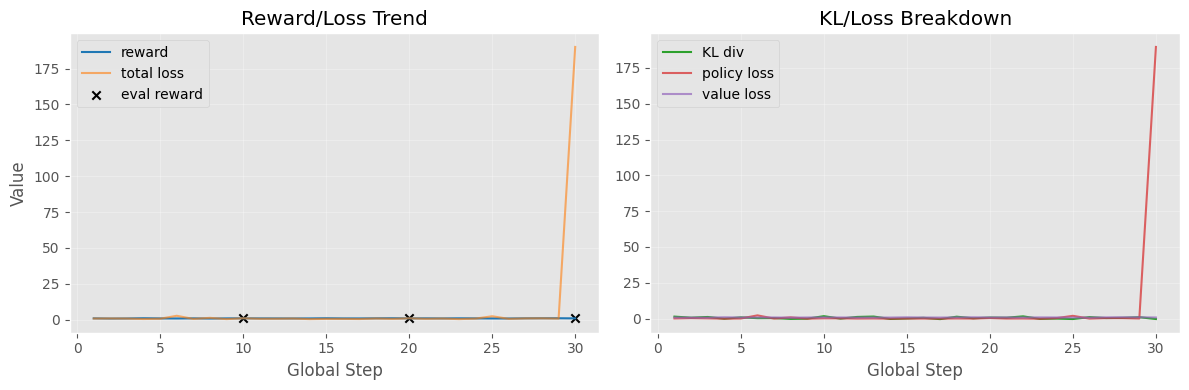

PPO step 1: loss=0.8147, reward=0.7696, kl=0.6494
PPO step 1: loss=0.7518, reward=0.8242, kl=1.1304
PPO step 1: loss=0.4272, reward=0.9598, kl=-0.0653
PPO step 1: loss=0.6272, reward=0.8566, kl=0.8561
PPO step 1: loss=2.6832, reward=0.8134, kl=0.3152
PPO step 1: loss=0.4961, reward=0.8865, kl=0.3733
PPO step 1: loss=1.2393, reward=0.7664, kl=-0.2259
PPO step 1: loss=0.3649, reward=0.8658, kl=-0.0331
PPO step 1: loss=0.9674, reward=0.9278, kl=1.6854
评估指标: {'samples': 120, 'toxicity_mean': 0.10479592722355544, 'toxicity_std': 0.2170729721613631, 'similarity_mean': 0.8718082308769226, 'reward_mean': 0.8781853349835729, 'reward_std': 0.17383137115350555}


,prompt,reference,prediction,toxicity,similarity,reward
0,"who the fuck is jared ? """,Who is Jared?,who is jared ?,0.001534,0.878410,0.962449
1,lol are you fucking kidding me .,lol are you kidding me .,Are you kidding me?,0.009384,0.800537,0.933592
2,fuck the hell out of that party .,Go out of the party.,Leave that party.,0.039535,0.686168,0.878176


Saved checkpoint to ppo_checkpoints/checkpoint-step00010
==== Epoch 2/3 ====
PPO step 1: loss=0.5907, reward=0.8636, kl=-0.0162
PPO step 1: loss=0.6245, reward=0.8476, kl=1.1624
PPO step 1: loss=0.7572, reward=0.8292, kl=1.4275
PPO step 1: loss=0.3625, reward=0.8381, kl=-0.2490
PPO step 1: loss=0.5157, reward=0.9486, kl=0.1022
PPO step 1: loss=0.5187, reward=0.8483, kl=0.5385
PPO step 1: loss=0.4193, reward=0.8316, kl=-0.3575
PPO step 1: loss=0.7854, reward=0.9302, kl=1.3254
PPO step 1: loss=0.5220, reward=0.9546, kl=0.2237
PPO step 1: loss=0.9351, reward=0.8863, kl=0.7399
评估指标: {'samples': 120, 'toxicity_mean': 0.1301147513174025, 'toxicity_std': 0.25514602148656557, 'similarity_mean': 0.8727675080299377, 'reward_mean': 0.8624166208447908, 'reward_std': 0.19771847296048775}


,prompt,reference,prediction,toxicity,similarity,reward
0,"who the fuck is jared ? """,Who is Jared?,who is jared ?,0.001534,0.878410,0.962449
1,lol are you fucking kidding me .,lol are you kidding me .,Are you kidding me?,0.009384,0.800537,0.933592
2,fuck the hell out of that party .,Go out of the party.,get out of that party .,0.479890,0.793795,0.602215


Saved checkpoint to ppo_checkpoints/checkpoint-step00020
==== Epoch 3/3 ====
PPO step 1: loss=0.5698, reward=0.9001, kl=0.6283
PPO step 1: loss=0.7554, reward=0.8517, kl=1.5667
PPO step 1: loss=0.3607, reward=0.9097, kl=-0.1704
PPO step 1: loss=0.7167, reward=0.8842, kl=0.0039
PPO step 1: loss=2.3610, reward=0.8248, kl=-0.3073
PPO step 1: loss=0.5414, reward=0.7977, kl=1.0383
PPO step 1: loss=0.8540, reward=0.9207, kl=0.3755
PPO step 1: loss=0.9074, reward=0.9628, kl=0.5336
PPO step 1: loss=0.7252, reward=0.9645, kl=0.9726
PPO step 1: loss=190.1055, reward=0.8777, kl=-0.2978
评估指标: {'samples': 120, 'toxicity_mean': 0.0976943501237353, 'toxicity_std': 0.20245578009068563, 'similarity_mean': 0.8797138929367065, 'reward_mean': 0.8888614661860144, 'reward_std': 0.16026415009660486}


,prompt,reference,prediction,toxicity,similarity,reward
0,"who the fuck is jared ? """,Who is Jared?,Who is jared?,0.001534,0.878410,0.962449
1,lol are you fucking kidding me .,lol are you kidding me .,Are you kidding me?,0.009384,0.800537,0.933592
2,fuck the hell out of that party .,Go out of the party.,Please leave that party.,0.001330,0.701303,0.909460


Saved checkpoint to ppo_checkpoints/checkpoint-step00030
训练日志已保存到 ppo_training_log.csv


,epoch,step_in_epoch,global_step,loss,policy_loss,value_loss,kl_div,reward_mean
25,3,6,26,0.541442,-0.015008,0.697584,1.038291,0.797708
26,3,7,27,0.853993,0.352577,0.852652,0.375451,0.920750
27,3,8,28,0.907442,0.336343,0.928749,0.533621,0.962776
28,3,9,29,0.725231,0.065378,0.930649,0.972641,0.964485
29,3,10,30,190.105484,189.656631,0.778592,-0.297767,0.877676


评估日志已保存到 ppo_eval_log.csv


,epoch,global_step,samples,toxicity_mean,toxicity_std,similarity_mean,reward_mean,reward_std
0,1,10,120,0.104796,0.217073,0.871808,0.878185,0.173831
1,2,20,120,0.130115,0.255146,0.872768,0.862417,0.197718
2,3,30,120,0.097694,0.202456,0.879714,0.888861,0.160264


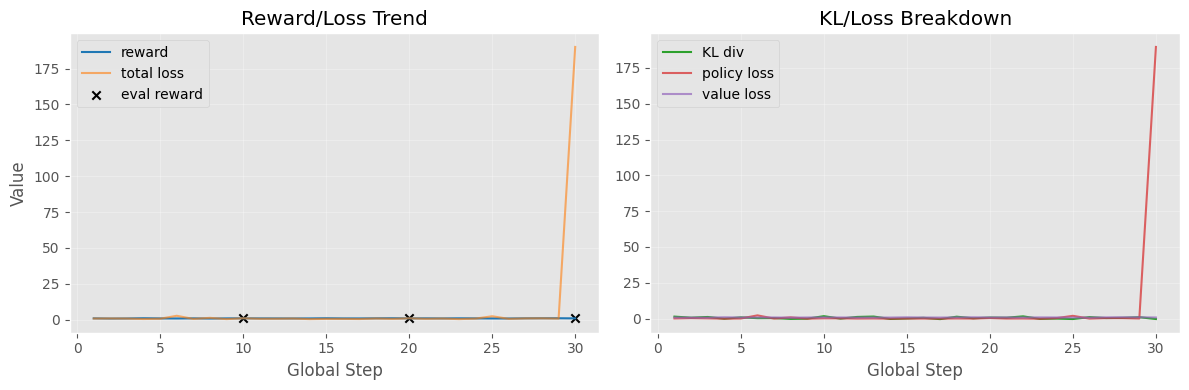

In [61]:
run_ppo_training(num_epochs=TRAINING_EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, eval_every=EVAL_EVERY_EPOCH)

## 9. 扩大规模 PPO 训练（自适应 KL + Outlier 保护）
在冒烟测试稳定后，进一步扩大训练规模：
- 使用更大的 batch size / epoch / step 数。
- 采用自适应 KL 系数自动调节策略收敛速度。
- 对异常大的 KL 或损失进行跳过，以避免梯度爆炸。
- 重新初始化训练/评估日志，保证与小规模阶段分离。


日志路径更新: ppo_training_log_large.csv ppo_eval_log_large.csv
==== Epoch 1/4 ====
PPO step 1: loss=0.7773, reward=0.9300, kl=0.4841, coef=0.220


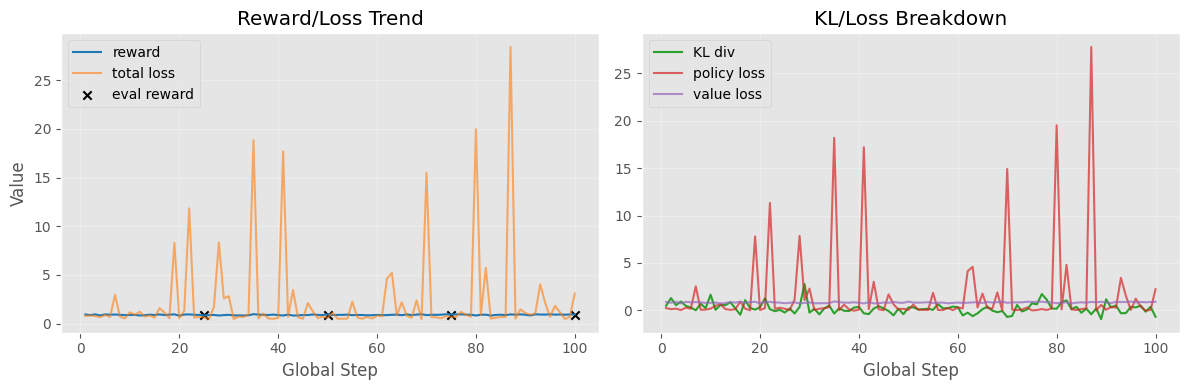

PPO step 1: loss=0.8351, reward=0.8706, kl=1.2894, coef=0.242
PPO step 1: loss=0.7667, reward=0.9443, kl=0.5450, coef=0.266
PPO step 1: loss=0.6647, reward=0.8310, kl=0.9262, coef=0.293
PPO step 1: loss=0.8856, reward=0.9421, kl=0.4683, coef=0.322
PPO step 1: loss=0.6727, reward=0.9151, kl=0.2936, coef=0.322
PPO step 1: loss=2.9691, reward=0.9301, kl=0.0063, coef=0.290
PPO step 1: loss=0.6867, reward=0.8968, kl=0.6877, coef=0.319
PPO step 1: loss=0.5419, reward=0.8700, kl=0.2362, coef=0.319
PPO step 1: loss=1.1531, reward=0.8810, kl=1.6486, coef=0.351
PPO step 1: loss=0.8946, reward=0.8896, kl=0.0439, coef=0.316
PPO step 1: loss=1.2129, reward=0.8303, kl=0.5629, coef=0.347
PPO step 1: loss=0.7109, reward=0.8556, kl=0.5440, coef=0.382
PPO step 1: loss=0.8384, reward=0.9191, kl=0.8553, coef=0.420
PPO step 1: loss=0.6094, reward=0.8768, kl=0.2082, coef=0.420
PPO step 1: loss=1.5876, reward=0.9448, kl=-0.4714, coef=0.462
PPO step 1: loss=1.1252, reward=0.8741, kl=1.0696, coef=0.508
PPO ste

,prompt,reference,prediction,toxicity,similarity,reward
0,"who the fuck is jared ? """,Who is Jared?,who is jared ?,0.001534,0.878409,0.962449
1,lol are you fucking kidding me .,lol are you kidding me .,lol are you kidding me .,0.019518,0.948015,0.970742
2,fuck the hell out of that party .,Go out of the party.,go out of that party,0.402939,0.770398,0.649062


Saved checkpoint to ppo_checkpoints/checkpoint-step00025
==== Epoch 2/4 ====
PPO step 1: loss=0.4904, reward=0.8743, kl=0.1874, coef=0.367
PPO step 1: loss=1.6775, reward=0.8866, kl=-0.3307, coef=0.367
PPO step 1: loss=8.3479, reward=0.8292, kl=0.3574, coef=0.367
PPO step 1: loss=2.5874, reward=0.8671, kl=2.7684, coef=0.404
PPO step 1: loss=2.8141, reward=0.8979, kl=-0.2426, coef=0.404
PPO step 1: loss=0.4700, reward=0.8351, kl=0.1678, coef=0.404
PPO step 1: loss=0.7177, reward=0.8414, kl=-0.4358, coef=0.404
PPO step 1: loss=0.6828, reward=0.8282, kl=0.2057, coef=0.404
PPO step 1: loss=0.9355, reward=0.8526, kl=0.4977, coef=0.444
PPO step 1: loss=18.8229, reward=0.9659, kl=-0.3413, coef=0.444
PPO step 1: loss=0.5379, reward=0.9211, kl=0.2125, coef=0.444
PPO step 1: loss=1.0257, reward=0.8958, kl=-0.0470, coef=0.400
PPO step 1: loss=0.5284, reward=0.8826, kl=-0.0808, coef=0.360
PPO step 1: loss=0.4886, reward=0.9197, kl=0.2852, coef=0.360
PPO step 1: loss=0.5904, reward=0.8741, kl=0.365

,prompt,reference,prediction,toxicity,similarity,reward
0,"who the fuck is jared ? """,Who is Jared?,Who is Jared?,0.001534,0.878409,0.962449
1,lol are you fucking kidding me .,lol are you kidding me .,lol are you kidding me .,0.019518,0.948015,0.970742
2,fuck the hell out of that party .,Go out of the party.,Please leave that party.,0.001330,0.701303,0.909460


Saved checkpoint to ppo_checkpoints/checkpoint-step00050
==== Epoch 3/4 ====
PPO step 1: loss=1.1193, reward=0.8829, kl=0.3205, coef=0.356
PPO step 1: loss=0.5007, reward=0.8886, kl=0.0836, coef=0.320
PPO step 1: loss=0.4990, reward=0.8938, kl=0.1216, coef=0.288
PPO step 1: loss=0.5114, reward=0.9200, kl=0.1658, coef=0.288
PPO step 1: loss=2.2472, reward=0.8641, kl=0.0509, coef=0.260
PPO step 1: loss=0.6253, reward=0.8852, kl=0.6520, coef=0.286
PPO step 1: loss=0.4955, reward=0.8806, kl=0.2111, coef=0.286
PPO step 1: loss=0.6832, reward=0.8457, kl=0.2232, coef=0.286
PPO step 1: loss=0.5180, reward=0.8613, kl=0.3922, coef=0.286
PPO step 1: loss=0.8137, reward=0.8831, kl=0.3260, coef=0.286
PPO step 1: loss=0.7604, reward=0.8691, kl=-0.5402, coef=0.314
PPO step 1: loss=4.6073, reward=0.8698, kl=-0.2487, coef=0.314
PPO step 1: loss=5.2171, reward=0.9017, kl=-0.6149, coef=0.345
PPO step 1: loss=0.8424, reward=0.9195, kl=-0.3210, coef=0.345
PPO step 1: loss=2.1811, reward=0.8618, kl=0.1209, 

,prompt,reference,prediction,toxicity,similarity,reward
0,"who the fuck is jared ? """,Who is Jared?,Who is Jared?,0.001534,0.878409,0.962449
1,lol are you fucking kidding me .,lol are you kidding me .,Are you kidding me?,0.009384,0.800537,0.933592
2,fuck the hell out of that party .,Go out of the party.,Leave that party,0.081272,0.657141,0.840252


Saved checkpoint to ppo_checkpoints/checkpoint-step00075
==== Epoch 4/4 ====
PPO step 1: loss=0.6846, reward=0.9415, kl=0.6313, coef=0.329
PPO step 1: loss=1.2055, reward=0.9509, kl=1.7163, coef=0.361
PPO step 1: loss=0.9017, reward=0.9159, kl=1.1162, coef=0.398
PPO step 1: loss=0.7032, reward=0.9059, kl=0.1942, coef=0.398
PPO step 1: loss=19.9687, reward=0.8316, kl=0.1648, coef=0.398
PPO step 1: loss=0.8804, reward=0.9015, kl=0.8634, coef=0.437
PPO step 1: loss=5.7208, reward=0.9138, kl=1.0454, coef=0.481
PPO step 1: loss=0.5178, reward=0.8180, kl=0.1163, coef=0.433
PPO step 1: loss=0.6019, reward=0.8888, kl=0.3703, coef=0.433
PPO step 1: loss=0.6625, reward=0.9088, kl=-0.2559, coef=0.433
PPO step 1: loss=0.6738, reward=0.8717, kl=0.1757, coef=0.433
PPO step 1: loss=28.4077, reward=0.9395, kl=-0.4220, coef=0.433
PPO step 1: loss=0.5067, reward=0.9161, kl=0.1997, coef=0.433
PPO step 1: loss=1.4637, reward=0.9471, kl=-0.9284, coef=0.476
PPO step 1: loss=1.0840, reward=0.9054, kl=1.1620,

,prompt,reference,prediction,toxicity,similarity,reward
0,"who the fuck is jared ? """,Who is Jared?,Who is Jared?,0.001534,0.878409,0.962449
1,lol are you fucking kidding me .,lol are you kidding me .,lol are you kidding me .,0.019518,0.948015,0.970742
2,fuck the hell out of that party .,Go out of the party.,leave that party.,0.039535,0.686168,0.878176


Saved checkpoint to ppo_checkpoints/checkpoint-step00100
训练日志已保存到 ppo_training_log_large.csv


,epoch,step_in_epoch,global_step,loss,policy_loss,value_loss,kl_div,reward_mean,adaptive_kl_coef,skipped
95,4,21,96,1.825574,1.225248,0.847157,0.306751,0.913865,0.576194,False
96,4,22,97,1.149790,0.400533,0.877250,0.490100,0.932778,0.633813,False
97,4,23,98,0.468380,-0.035713,0.844314,-0.143640,0.909769,0.570432,False
98,4,24,99,0.689998,0.039216,0.875617,0.373355,0.933423,0.570432,False
99,4,25,100,3.098075,2.223335,0.896449,-0.679733,0.945531,0.627475,False


评估日志已保存到 ppo_eval_log_large.csv


,epoch,global_step,samples,toxicity_mean,toxicity_std,similarity_mean,reward_mean,reward_std
0,1,25,200,0.116354,0.225797,0.884325,0.872849,0.179014
1,2,50,200,0.091184,0.191522,0.877636,0.894462,0.151292
2,3,75,200,0.092454,0.200639,0.866577,0.888255,0.156661
3,4,100,200,0.102231,0.214834,0.877544,0.884701,0.163808


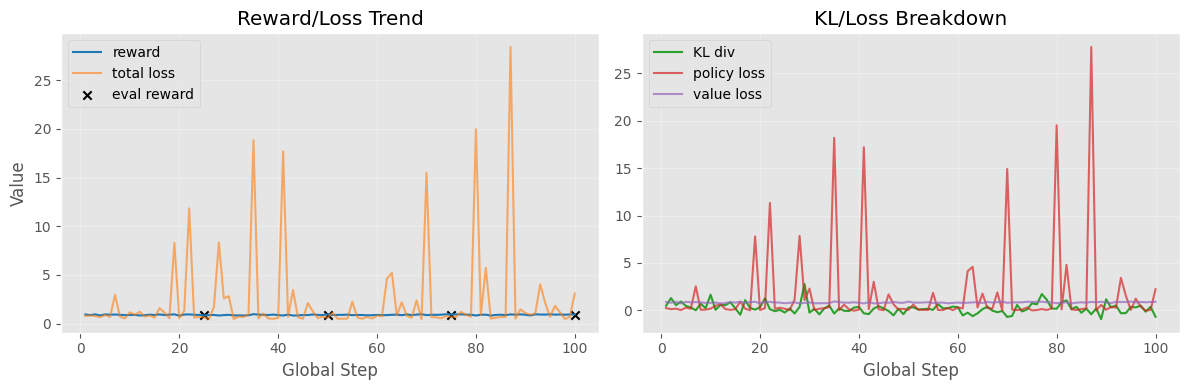

In [67]:
LOG_PATH = 'ppo_training_log_large.csv'
EVAL_LOG_PATH = 'ppo_eval_log_large.csv'
EVAL_SAMPLE_SIZE = LARGE_EVAL_SAMPLE_SIZE
print('日志路径更新:', LOG_PATH, EVAL_LOG_PATH)

run_ppo_training(
    num_epochs=LARGE_TRAINING_EPOCHS,
    steps_per_epoch=LARGE_STEPS_PER_EPOCH,
    eval_every=LARGE_EVAL_EVERY,
    train_loader=rl_train_loader_large,
)

In [66]:
LARGE_TRAINING_EPOCHS = 4
LARGE_STEPS_PER_EPOCH = 25
LARGE_EVAL_EVERY = 1
LARGE_EVAL_SAMPLE_SIZE = 200
LARGE_BATCH_SIZE = 16

print({
    'epochs': LARGE_TRAINING_EPOCHS,
    'steps_per_epoch': LARGE_STEPS_PER_EPOCH,
    'eval_every': LARGE_EVAL_EVERY,
    'eval_sample_size': LARGE_EVAL_SAMPLE_SIZE,
    'batch_size': LARGE_BATCH_SIZE,
})

rl_train_loader_large = DataLoader(
    PromptDataset(rl_train_dataset['prompt']),
    batch_size=LARGE_BATCH_SIZE,
    shuffle=True,
    collate_fn=lambda batch: collate_prompts(batch),
)
print(f'Large-scale RL loader batches: {len(rl_train_loader_large)}')

training_history = []
evaluation_history = []
adaptive_kl_state['coef'] = KL_COEF
print('重置训练/评估历史与 KL 系数。')

{'epochs': 4, 'steps_per_epoch': 25, 'eval_every': 1, 'eval_sample_size': 200, 'batch_size': 16}
Large-scale RL loader batches: 500
重置训练/评估历史与 KL 系数。
